In [1]:
import torch.nn as nn # importing torch.nn as nn

In [2]:
!pip install torch torchvision #installing torchvision package

In [3]:
import torch # importing torch
from torchvision import datasets # importing datasets from torchvision
from torchvision.transforms import ToTensor, Lambda #importing ToTensor and Lambda
from torch.utils.data import Dataset, random_split

In [4]:
import pandas as pd

In [5]:
import torch # importing torch
from torchvision import datasets # importing datasets from torchvision
from torchvision.transforms import ToTensor, Lambda #importing ToTensor and Lambda

ds_train = datasets.CIFAR10(  # Getting dataset (training) from FashionMNIST
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor(), # this converts the image into a tensor
    target_transform= Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0,torch.tensor(y), value=1))
    # This creates a tensor of zeros with a shape of (10,), indicating that there are 10 possible classes or labels. The dtype is set to float.
)

test_dataset = datasets.CIFAR10(  # Getting dataset (testing) from FashionMNIST
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor(), # this converts the image into a tensor
    target_transform= Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0,torch.tensor(y), value=1))
    # This creates a tensor of zeros with a shape of (10,), indicating that there are 10 possible classes or labels. The dtype is set to float.
)

100%|██████████| 170498071/170498071 [00:05<00:00, 29326227.87it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [6]:
# this chunk is used to get the validation datset from the training dataset
from torch.utils.data import random_split # importing random_split


train_size = len(ds_train) # taking length of the training set
val_size = int(0.1 * train_size)  # Taking 10% of the training set for validation

train_dataset, val_dataset = random_split(ds_train, [train_size - val_size, val_size]) # seperating into 90% of training into new training and 10% of training to validation

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")


Training set size: 45000
Validation set size: 5000


In [7]:
print(f"Test set size: {len(test_dataset)}")

Test set size: 10000


## Defining the Network Architecture

In [20]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(3,32,3,1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace = True),
        nn.Conv2d(32,64,3,1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
    )
    self.block2 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(12544,128),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(128,10),
        nn.BatchNorm1d(10)
    )

  def forward(self,x):
    x = self.block1(x)
    return self.block2(x)

In [21]:
net = Net()

In [22]:
import torch.optim as optim #importing optim

In [23]:
criterion = nn.CrossEntropyLoss()  # Taking Cross Entropy Loss as the Loss function
optimizer = optim.SGD(net.parameters(), lr=0.01)  # optimizer is SGD stochastic gradient descent


# Creating DataLoaders

In [24]:
from torch.utils.data import DataLoader # importing dataloader

In [25]:
# loading all the datasets into dataloader for feeding into the model by batches

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Printing the image

In [26]:
train_features,train_labels = next(iter(train_loader))

In [27]:
train_features[0].shape

torch.Size([3, 32, 32])

Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64, 10])


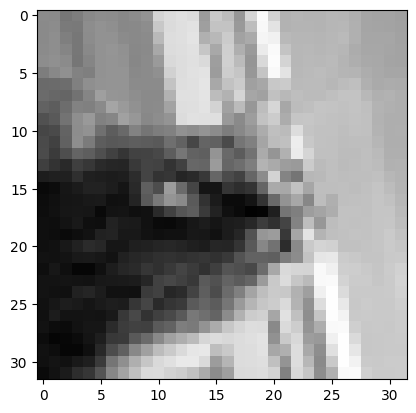

Label: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])


In [32]:
import matplotlib.pyplot as plt


print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Select the first image from the batch
img = train_features[0].squeeze().permute(1, 2, 0)
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


## Training and Validating the Model

In [17]:
def trainval_loop(train_loader, val_loader, net, criterion, optimizer): #parameters for the function
    # Set the model to training mode before entering loops
    net.train()

    # Training loop
    size = len(train_loader.dataset)
    for batch, (X, y) in enumerate(train_loader):
        # Compute prediction and loss (training)
        pred = net(X)
        loss = criterion(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() # this is done to deny the involement of the previous gradients interference with the current ones

        if batch % 100 == 0:
            current = batch * len(X)
            print(f"Training loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]") #printing training loss

    # Set the model to evaluation mode before validation
    net.eval()

    # Validation loop
    val_loss = 0
    val_size = len(val_loader.dataset)
    with torch.no_grad():  # No need to compute gradients during validation
        for batch, (X, y) in enumerate(val_loader):
            # Compute prediction and loss
            pred = net(X)
            loss = criterion(pred, y)
            val_loss += loss.item()

            if batch % 100 == 0:
                current = batch * len(X)
                print(f"Validation loss: {loss.item():>7f}  [{current:>5d}/{val_size:>5d}]") #printing validation loss

    avg_val_loss = val_loss / len(val_loader)
    print(f"Avg. Validation loss: {avg_val_loss:>7f}") #printing average validation loss



## Testing the Model

In [18]:
# this chunk is important for testing the model
def test_loop(test_loader, net, criterion): # function test_loop taking these respective parameters
    net.eval() # setting the model to eval
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in test_loader:
            pred = net(X)
            test_loss += criterion(pred, y).item()

            # Calculate the number of correct predictions in this batch
            pred_labels = pred.argmax(dim=1)
            y= y.argmax(dim=1)
            #print(pred_labels,y)
            correct += (pred_labels == y).sum().item()

    test_loss /= num_batches
    accuracy = correct / size
    print(f"Test Error: \n Accuracy: {(100*accuracy):.2f}%, Avg loss: {test_loss:.8f} \n") # printint the Accuracy (TEST) and the test_loss


## Now Training and Validation

In [40]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    trainval_loop(train_loader,val_loader, net, criterion, optimizer) # running train_val loop by 10 times
print("Done!")

Epoch 1
-------------------------------
Training loss: 0.910181  [    0/45000]
Training loss: 0.650464  [ 6400/45000]
Training loss: 0.719887  [12800/45000]
Training loss: 0.682397  [19200/45000]
Training loss: 0.496460  [25600/45000]
Training loss: 0.725184  [32000/45000]
Training loss: 0.694863  [38400/45000]
Training loss: 0.684219  [44800/45000]
Validation loss: 0.849406  [    0/ 5000]
Avg. Validation loss: 0.959828
Epoch 2
-------------------------------
Training loss: 0.566456  [    0/45000]
Training loss: 0.655020  [ 6400/45000]
Training loss: 0.630510  [12800/45000]
Training loss: 0.747386  [19200/45000]
Training loss: 0.859600  [25600/45000]
Training loss: 0.584530  [32000/45000]
Training loss: 0.578091  [38400/45000]
Training loss: 0.723399  [44800/45000]
Validation loss: 0.932030  [    0/ 5000]
Avg. Validation loss: 1.117306
Epoch 3
-------------------------------
Training loss: 0.693233  [    0/45000]
Training loss: 0.767393  [ 6400/45000]
Training loss: 0.521582  [12800/45

# Testing

In [41]:
test_loop(test_loader, net, criterion) #test_loop running and checking the results


Test Error: 
 Accuracy: 62.17%, Avg loss: 1.12349482 

